## Importing Libraries

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from prettytable import PrettyTable
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS, WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string, unicodedata
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [4]:
%%time
df = pd.read_csv("Dataset\IMDB-Dataset.csv", encoding='latin-1')
df.head()

CPU times: total: 3.22 s
Wall time: 6.17 s


,Ratings,Reviews,Movies,Resenhas
0,1.0,*Disclaimer: I only watched this movie as a co...,Disaster Movie,* IsenÃ§Ã£o de responsabilidade: eu sÃ³ assist...
1,1.0,I am writing this in hopes that this gets put ...,Disaster Movie,Estou escrevendo isso na esperanÃ§a de que iss...
2,1.0,"Really, I could write a scathing review of thi...",Disaster Movie,"Realmente, eu poderia escrever uma crÃ­tica co..."
3,1.0,If you saw the other previous spoof movies by ...,Disaster Movie,Se vocÃª viu os outros filmes falsificados ant...
4,1.0,This movie I saw a day early for free and I st...,Disaster Movie,Este filme eu vi um dia cedo de graÃ§a e ainda...


In [5]:
#Customize stopword as per data
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords = ["would","shall","could","might"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words=set(stop_words)
print(stop_words)

{"won't", 'own', 'up', 'didn', 'doing', 'did', 'isn', 'aren', 'each', "haven't", "don't", 'our', "wasn't", 'he', 'no', 'down', 'it', 'be', "shouldn't", "she's", 'on', 'wouldn', 'ain', 'her', 'was', 'yourself', 'to', 'hers', 'very', 'were', 'below', 'in', 'above', 'ours', "weren't", 'those', 'won', "that'll", 'him', 'then', 'yourselves', 'an', 'myself', 'where', 'might', 'shall', 'than', 'll', 'or', 'my', 'about', 'from', 'these', 'only', 'a', 'you', 's', "hadn't", "hasn't", "you've", 'which', 'don', 'had', 'its', 'between', 'off', 'o', 're', 'who', 'hasn', "wouldn't", 'with', 'by', 'most', 'm', 'at', "couldn't", 'there', 'yours', 'itself', 'too', 'into', 'will', 'how', 'through', "doesn't", 'this', 'has', 'do', "isn't", 't', 'weren', 'because', 'being', 'that', "you're", 'his', 'd', 'would', 'themselves', 'could', 'ourselves', 'theirs', 'your', "should've", 've', 'shouldn', 'if', 'over', 'other', "didn't", 'should', 'out', 'so', 'some', 'i', 'couldn', 'mustn', 'once', 'the', 'been', 'c

In [6]:
#Removing special character
def remove_special_character(content):
    return re.sub('\W+',' ', content )

# Removing URL's
def remove_url(content):
    return re.sub(r'http\S+', '', content)

#Removing the stopwords
def remove_stopwords(content):
    clean_data = []
    for i in content.split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

# Expansion of english contractions
def contraction_expansion(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"needn\'t", "need not", content)
    content = re.sub(r"hasn\'t", "has not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"mightn\'t", "might not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"n\'t", " not", content)

    return content

#Data preprocessing
def data_cleaning(content):
    content = contraction_expansion(content)
    content = remove_special_character(content)
    content = remove_url(content)
    content = remove_stopwords(content)   
    
    return content

In [7]:
pd.options.display.max_colwidth = 1000

df['Cleaned_Reviews']=df['Reviews'].apply(data_cleaning)
df.head()

,Ratings,Reviews,Movies,Resenhas,Cleaned_Reviews
0,1.0,"*Disclaimer: I only watched this movie as a conditional agreement. And I see films for free. I wouldn't be caught dead giving my hard earned money to these idiots.Well, to explain the depth of this 'film', I could write my shortest review, ever. Don't see this movie. It is by far the stupidest, lamest, most lazy, and unbelievably UNFUNNY movie I have ever seen. It is a total disaster. But since my hatred for this movie, and the others like it, extends far beyond one viewing, I think I'll go on for a bit.I don't know any of the people in the movie besides Carmen Electra, Vanessa Minnillo, and Kim Kardashian, but it doesn't matter. They're all horrible, though I think that was the point. The editing is flat out horrible, and possibly blatant continuity errors make this crapfast even crappier than I thought it would be. Now I know that these films are not supposed to be serious at all, but come on, it's film-making 101 that if someone gets a minor facial cut, it should be there in the...",Disaster Movie,"* IsenÃ§Ã£o de responsabilidade: eu sÃ³ assisti esse filme como um acordo condicional. E eu vejo filmes de graÃ§a. Eu nÃ£o seria pego morto dando meu dinheiro suado a esses idiotas. Bem, para explicar a profundidade desse 'filme', eu poderia escrever minha crÃ­tica mais curta de todos os tempos. NÃ£o vÃª este filme. Ã de longe o filme mais estÃºpido, lamenta, preguiÃ§oso e inacreditavelmente UNFUNNY que eu jÃ¡ vi. Ã um desastre total. Mas como o meu Ã³dio por este filme e por outros, se estende muito alÃ©m de uma exibiÃ§Ã£o, acho que vou continuar um pouco. NÃ£o conheÃ§o nenhuma das pessoas do filme alÃ©m de Carmen Electra, Vanessa Minnillo, e Kim Kardashian, mas isso nÃ£o importa. Eles sÃ£o todos horrÃ­veis, embora eu ache que esse seja o ponto. A ediÃ§Ã£o Ã© horrÃ­vel e, possivelmente, erros de continuidade flagrantes tornam essa porcaria ainda mais horrÃ­vel do que eu pensava. Agora eu sei que esses filmes nÃ£o devem ser sÃ©rios, mas vamos lÃ¡, Ã© o cinema 101 que se alguÃ©m f...",disclaimer watched movie conditional agreement see films free not caught dead giving hard earned money idiots well explain depth film write shortest review ever not see movie far stupidest lamest lazy unbelievably unfunny movie ever seen total disaster since hatred movie others like extends far beyond one viewing think go bit not know people movie besides carmen electra vanessa minnillo kim kardashian not matter horrible though think point editing flat horrible possibly blatant continuity errors make crapfast even crappier thought know films not supposed serious come film making someone gets minor facial cut next shot someone gets cut sword blood least cut though since narnia films get away give disaster movie pass jokes thoughtless mindless physical gags obviously take popular movies last year late well including best picture nominees know saddest thing stupid movies not care much money make many cameos sorry ass excuses films taking away jobs actors writers directors truly deserv...
1,1.0,"I am writing this in hopes that this gets put over the previous review of this ""film"". How anyone can find this slop entertaining is completely beyond me. First of all a spoof film entitled ""Disaster Movie"", should indeed be a spoof on disaster films. Now I have seen 1 (yes count them, 1) disaster film being spoofed, that being ""Twister"". How does Juno, Iron Man, Batman, The Hulk, Alvin and the Chipmunks, Amy Winehouse, or Hancock register as Disaster films? Selzterwater and Failburg once again have shown that they lack any sort of writing skill and humor. Having unfortunately been tortured with Date Movie and Epic Movie I know exactly what to expect from these two...no plot, no jokes just bad references and cheaply remade scenes from other films. Someone should have informed them that satire is more than just copy and paste from one film to another, though I shouldn't say that because some of these 

In [8]:
# Maping Labels to ratings -- 1(positive) 0(negative) 2(neutral)
df['Label'] = df['Ratings'].apply(lambda x: 1 if x >=7 else (0 if x<=4 else 2))

# Removing the neutral ratings
df = df[df['Label']<2]
data = df[['Cleaned_Reviews','Label']]
data['Label'].value_counts()

Label
0    60000
1    60000
Name: count, dtype: int64

## Lemmatization

In [10]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wordnetlemma = WordNetLemmatizer()
    def __call__(self, reviews):
        return [self.wordnetlemma.lemmatize(word) for word in word_tokenize(reviews) ]

In [11]:
train, test = train_test_split(data, test_size=0.3, random_state=31, shuffle=True)

tfidfvec = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), min_df=10, ngram_range=(1,3), max_features=1000)

X_train_tfidf = tfidfvec.fit_transform(train['Cleaned_Reviews']).toarray()
X_test_tfidf = tfidfvec.transform(test['Cleaned_Reviews']).toarray()

y_train = train['Label']
y_test = test['Label']

## Logistic Regression Model (Hyper Tunned)

In [13]:
model = LogisticRegression(C=1.0, max_iter=100, penalty='l2', tol=0.0001, dual=False, solver='lbfgs')
model.fit(X_train_tfidf,y_train)

LogisticRegression()

In [14]:
print("************************ Performance for Logistic Regresison *******************************")
print("Precision Score for Logistic Regression: %s" % precision_score(y_test,model.predict(X_test_tfidf),average='micro'))
print("Recall Score for Logistic Regression: %s" % recall_score(y_test,model.predict(X_test_tfidf),average='micro'))
print("AUC Score for Logistic Regression: %s" % roc_auc_score(y_test,model.predict_proba(X_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score =f1_score(y_test,model.predict(X_test_tfidf),average="weighted")
print("F1 Score for Logistic Regression: %s" % f1_score)
print("Accuracy Score for Logistic Regression: %s" % accuracy_score(y_test,model.predict(X_test_tfidf)))

************************ Performance for Logistic Regresison *******************************
Precision Score for Logistic Regression: 0.8665277777777778
Recall Score for Logistic Regression: 0.8665277777777778
AUC Score for Logistic Regression: 0.939834097094157
F1 Score for Logistic Regression: 0.8665260913317981
Accuracy Score for Logistic Regression: 0.8665277777777778


In [15]:
y_predict=model.predict(X_test_tfidf)
y_predict_prob=model.predict_proba(X_test_tfidf)[:,1]

## Confusion Metrics

In [17]:
def plot_confusion(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test,y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(conf_matrix)
    ax.grid = False
    ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5,-0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j,i, conf_matrix[i,j], ha='center', va='center', color='red')
    plt.show()

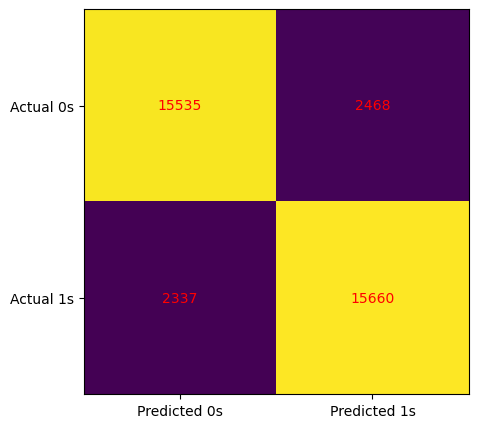

In [18]:
plot_confusion(y_test,y_predict)